In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from copy import copy
from tqdm import tqdm
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt

from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin
from runc import *
from ensembles import GradientBoostingMSE
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from scipy.optimize import minimize
import numpy.ma as mask
from sklearn.dummy import DummyRegressor

## Boosting  с минимизацией перебором по покрытиям

In [1]:
class BoostingElementaryPredicates(BaseEstimator, RegressorMixin):
    def __init__(self, num_iter, m):
        self.num_iter = num_iter
        self.m = m
        self.h = []  # weak learners
        self.gamma = []  # coefficients for the learners
        self.covers = [] # covers for the learners
        # self.runc = RuncDualizer()
        self.base_value = None
        self.key_objects = [] # "bad" objects for the learners
        
    def fit(self, X, y):
        self.base_value = y_hat = y.mean()
        # print(y)
        # print('------')

        for _ in range(self.num_iter):
            # print(y_hat)
            residuals = y - y_hat
            # print(residuals)
            # print('------')
            max_residual_idx = np.argmax(np.abs(residuals))

            self.runc = RuncDualizer() # create new Dualizer
           
            sorted_residual_indices = np.argsort(np.abs(residuals))
            min_m_residual_indices = sorted_residual_indices[:self.m]
            key_object = X[max_residual_idx]
            
            for row_idx in min_m_residual_indices:
                row = X[row_idx]
                non_zero_indices = np.where(row != X[max_residual_idx])[0]
                if len(non_zero_indices) > 0:
                    self.runc.add_input_row(list(row))
            comp_rows=[]
            for idx in min_m_residual_indices:
                comp_row = []
                for j in range(X.shape[1]):
                    if X[idx, j] == key_object[j]:
                        comp_row.extend([1, 0, 0])  # Равно
                    elif X[idx, j] < key_object[j]:
                        comp_row.extend([0, 1, 0])  # Меньше
                    else:
                        comp_row.extend([0, 0, 1])  # Больше
                comp_rows.append(comp_row)
                self.runc.add_input_row(comp_row)
            print(len(comp_rows), len(comp_rows[0]))
            print(comp_rows)

            h_m, min_residual_sum, gamma_m = 0, float('inf'), 0
            # X_other = X[sorted_residual_indices[self.m:]]

            while True:
                covers = self.runc.enumerate_covers()
                if len(covers) == 0:
                    break

                for cover in covers:
                    h_mask = np.isin(np.arange(X.shape[1]), cover)
                    base_estimator = residuals[max_residual_idx] * np.where((X[:, h_mask] == X[max_residual_idx][h_mask]).all(axis=1), 1, 0)
                    residual_sum_maybe = ((y - y_hat - base_estimator) ** 2).mean()
                    if residual_sum_maybe < min_residual_sum:
                        h_m, min_residual_sum = base_estimator, residual_sum_maybe
                        best_cover = cover
                        # gamma_m = self.optimize(y, y_hat, h_m)[0]
            # print(min_residual_sum)
            self.h.append(h_m)
            gamma_m = self.optimize(y, y_hat, h_m)[0]
            self.gamma.append(gamma_m)
            self.covers.append(best_cover)
            self.key_objects.append(X[max_residual_idx])
            y_hat += gamma_m * h_m
        
            del(self.runc)
        
        return self

    def optimize(self, y, y_hat, h):
        loss = lambda gamma: ((y - y_hat - gamma * h) ** 2).mean()
        result = minimize(loss, x0=0.0)
        return result.x
    
    def predict(self, X):
        y_pred = np.full(X.shape[0], self.base_value)
        for i in range(len(self.h)):
            h_mask = np.isin(np.arange(X.shape[1]), self.covers[i])
            res = np.unique(self.h[i][self.h[i] != 0.])
            base_estimator = res * np.where((X[:, h_mask] == self.key_objects[i][h_mask]).all(axis=1), 1, 0)
            y_pred += base_estimator.reshape(-1)

        return y_pred

NameError: name 'BaseEstimator' is not defined

In [3]:
class BoostingElementaryPredicates1(BaseEstimator, RegressorMixin):
    def __init__(self, num_iter, m):
        self.num_iter = num_iter
        self.m = m
        self.h = []  # weak learners
        self.gamma = []  # coefficients for the learners
        self.covers = [] # covers for the learners
        # self.runc = RuncDualizer()
        self.base_value = None
        self.key_objects = [] # "bad" objects for the learners
        self.train_losses = []  # train loss for each iteration
        self.test_losses = []  # test loss for each iteration
        
    def fit_predict(self, X_train, y_train, X_test, y_test):
        self.base_value = y_hat = y_train.mean()

        for _ in range(self.num_iter):
            residuals = y_train - y_hat
            max_residual_idx = np.argmax(np.abs(residuals))

            self.runc = RuncDualizer()  # create new Dualizer
           
            sorted_residual_indices = np.argsort(np.abs(residuals))
            min_m_residual_indices = sorted_residual_indices[:self.m]
            
            for row_idx in min_m_residual_indices:
                row = X_train[row_idx]
                non_zero_indices = np.where(row != X_train[max_residual_idx])[0]
                if len(non_zero_indices) > 0:
                    self.runc.add_input_row(list(row))

            h_m, min_residual_sum, gamma_m = 0, float('inf'), 0

            while True:
                covers = self.runc.enumerate_covers()
                if len(covers) == 0:
                    break

                for cover in covers:
                    h_mask = np.isin(np.arange(X_train.shape[1]), cover)
                    base_estimator = residuals[max_residual_idx] * np.where((X_train[:, h_mask] == X_train[max_residual_idx][h_mask]).all(axis=1), 1, 0)
                    residual_sum_maybe = ((y_train - y_hat - base_estimator) ** 2).mean()
                    if residual_sum_maybe < min_residual_sum:
                        h_m, min_residual_sum = base_estimator, residual_sum_maybe
                        best_cover = cover

            self.h.append(h_m)
            gamma_m = self.optimize(y_train, y_hat, h_m)[0]
            self.gamma.append(gamma_m)
            self.covers.append(best_cover)
            self.key_objects.append(X_train[max_residual_idx])
            y_hat += gamma_m * h_m

            # Calculate train and test loss for current iteration
            train_loss = ((y_train - self.predict(X_train)) ** 2).mean()
            test_loss = ((y_test - self.predict(X_test)) ** 2).mean()
            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)

        # Plot the train and test loss
        x = np.arange(self.num_iter) + 1
        plt.plot(x, self.train_losses, label='Train Loss')
        plt.plot(x, self.test_losses, label='Test Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def optimize(self, y, y_hat, h):
        loss = lambda gamma: ((y - y_hat - gamma * h) ** 2).mean()
        result = minimize(loss, x0=0.0)
        return result.x
    
    def predict(self, X):
        y_pred = np.full(X.shape[0], self.base_value)
        for i in range(len(self.h)):
            h_mask = np.isin(np.arange(X.shape[1]), self.covers[i])
            res = np.unique(self.h[i][self.h[i] != 0.])
            base_estimator = res * np.where((X[:, h_mask] == self.key_objects[i][h_mask]).all(axis=1), 1, 0)
            y_pred += base_estimator.reshape(-1)

        return y_pred

## Baseline

In [6]:
# Генерация случайных данных для регрессии
X, y = make_regression(n_samples=50, n_features=10, n_informative=5, random_state=42)

# Инициализация класса KBinsDiscretizer
encoder = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Применение KBinsDiscretizer к данным X
X_encoded = encoder.fit_transform(X)

X_encoded = X_encoded.astype('int64')

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [9]:
# n_features = X_encoded.shape[1]
# fig, axes = plt.subplots(nrows=n_features, ncols=1, figsize=(8, 20))
# for i in range(n_features):
#     ax = axes[i]
#     ax.hist(X_encoded[:, i], bins=10, color='blue', edgecolor='black')
#     ax.set_title(f'Feature {i + 1}')
#     ax.set_xlabel('Bins')
#     ax.set_ylabel('Count')
# plt.tight_layout()
# plt.show()

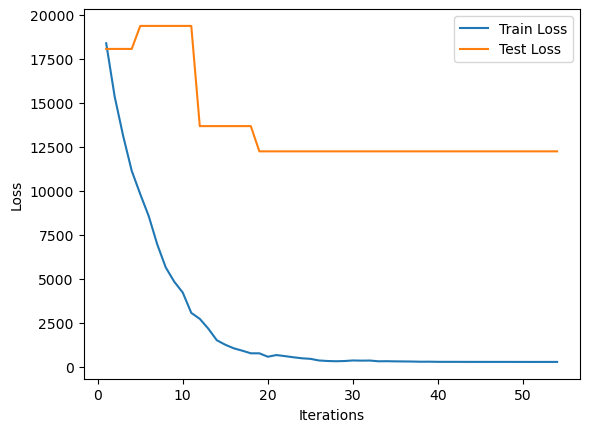

In [26]:
model = BoostingElementaryPredicates1(num_iter=54, m=10)
model.fit_predict(X_train, y_train, X_test, y_test)

In [535]:
model = BoostingElementaryPredicates(54, 10)
model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

18370.982246940606
15333.145441534763
13093.611826996177
11127.888240461238
9615.65207164002
8361.25310540551
6758.409962165626
5440.20204906853
4622.6033030319295
3943.196997060654
2790.3504851982975
2451.1253984877667
1895.5667105603497
1564.9461964981108
1283.2972881714215
1079.9069982072144
945.3773948978035
797.3174625730383
678.5210748010379
473.0107372216141
377.67899164165
317.9431973433619
252.23361701440263
188.54303558509497
157.17310333763595
126.28859308837468
96.51740443578265
82.19768381852438
69.53084288953343
56.86400396525462
46.82886882616897
41.449087923003404
36.06930788560785
31.598198933895606
24.32164034336634
19.69177760938882
12.785538871453916
9.343874919311721
6.610174978505414
3.8764756881359346
2.50358713055302
1.8961492268432856
1.288711353289758
0.8020709088053841
0.5369703064284682
0.2718697158077924
0.22474128955676403
0.17761296084855702
0.09345472831039629
0.04765855752864011
0.008876189865273693
0.004508152751067215
0.00014011850042138025
7.00592243

Алгоритм корректно обучается, минимизируя среднеквадратичную ошибку.

In [44]:
# Генерация случайных данных для регрессии
X, y = make_regression(n_samples=100, n_features=20, n_informative=10, random_state=42)

# Инициализация класса KBinsDiscretizer
encoder = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

# Применение KBinsDiscretizer к данным X
X_encoded = encoder.fit_transform(X)

X_encoded = X_encoded.astype('int64')

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [10]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [28]:
param_grid = {
    "num_iter" : np.linspace(10, 210, 10).astype(int),
    "m" : np.linspace(5, 45, 10).astype(int)
}

model_to_tune = BoostingElementaryPredicates(8, 3)

grid_search = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, scoring=rmse_scorer, cv=3, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшее значение R2:", np.abs(grid_search.best_score_))

Лучшие параметры: {'m': 5, 'num_iter': 10}
Лучшее значение R2: 190.90802629932128


In [7]:
# Создание и обучение модели BoostingRegressor
# model = GradientBoostingRegressor()
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

# print('RMSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

model = BoostingElementaryPredicates(54, 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Вычисление среднеквадратичной ошибки
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2_score:", r2)

model = GradientBoostingRegressor()
model.fit(X, y)
y_pred = model.predict(X_test)
# Вычисление среднеквадратичной ошибки
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2_score:", r2)

# Сравнение с простой моделью Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print("Mean Squared Error (Linear Regression):", mse_linear)
print("R2_score (Linear Regression):", r2_linear)

: 

: 

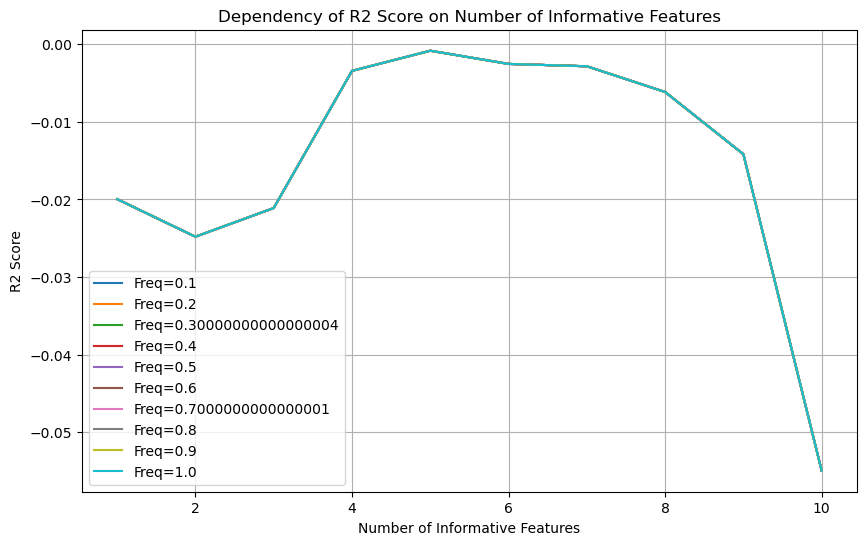

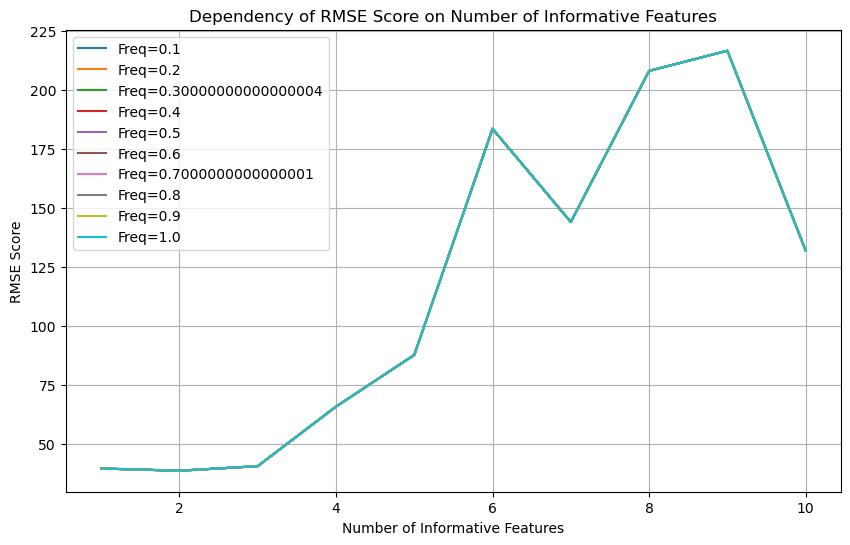

In [34]:
informative_features = np.arange(1, 11)  
freqs = np.arange(0.1, 1.1, 0.1)  

r2_scores = np.zeros((len(informative_features), len(freqs)))
rmse_scores = np.zeros((len(informative_features), len(freqs)))

for i, n_informative in enumerate(informative_features):
    for j, freq in enumerate(freqs):
        X, y = make_regression(n_samples=100, n_features=20, n_informative=n_informative, noise=0.1, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        num_iter = 10
        m = 5

        model = BoostingElementaryPredicates(num_iter, m)
        
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        r2_scores[i, j] = r2_score(y_test, y_pred)
        rmse_scores[i, j] = np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(10, 6))
for j in range(len(freqs)):
    plt.plot(informative_features, r2_scores[:, j], label=f'Freq={freqs[j]}')
plt.xlabel('Number of Informative Features')
plt.ylabel('R2 Score')
plt.title('Dependency of R2 Score on Number of Informative Features')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for j in range(len(freqs)):
    plt.plot(informative_features, rmse_scores[:, j], label=f'Freq={freqs[j]}')
plt.xlabel('Number of Informative Features')
plt.ylabel('RMSE Score')
plt.title('Dependency of RMSE Score on Number of Informative Features')
plt.legend()
plt.grid(True)
plt.show()


### Auto-MPG

In [18]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [19]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


# Предобработка

In [48]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [21]:
dataset = dataset.dropna()

In [23]:
dataset = dataset.astype('int64')
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18,8,307,130,3504,12,70,1
1,15,8,350,165,3693,11,70,1
2,18,8,318,150,3436,11,70,1
3,16,8,304,150,3433,12,70,1
4,17,8,302,140,3449,10,70,1
...,...,...,...,...,...,...,...,...
393,27,4,140,86,2790,15,82,1
394,44,4,97,52,2130,24,82,2
395,32,4,135,84,2295,11,82,1
396,28,4,120,79,2625,18,82,1


In [24]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [27]:
y = dataset['MPG']
X = dataset.drop(columns='MPG')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
import warnings
warnings.filterwarnings('ignore')

In [33]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print("R2_score (Linear Regression):", r2_linear)
print("Mean Squared Error (Linear Regression):", mse_linear)

R2_score (Linear Regression): 0.7894461784802311
Mean Squared Error (Linear Regression): 10.727415258554867
